In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import os
from sys import platform
import f90nml
from importlib import reload
import sys
sys.path.append('../ice2019')
import retrievestuff as rs
import weibull
import scipy.stats as stats

In [2]:
%matplotlib notebook

In [3]:
# Have to do this in case of different operating systems
if platform == "linux" or platform == "darwin":
    slash = '/'
else: # This is assumed to be Windows
    slash = '\\'
#print(slash)

In [4]:
foldername = "Case2.0 (calibration)"; filename = "surface_filtered.txt"

# Load a height file (for synthetic data)
#filename = "surface.txt"

sollast = np.loadtxt(foldername+slash+filename)
Ny, Nx = np.shape(sollast); #print(sollast.shape)
Ntot = np.size(sollast)
print("Nx =", Nx)
print("Ny =", Ny)
print('Npts = ', Ntot)

# Get other parameters
params = f90nml.read(foldername+slash+'parameters.nml')
Lx = params['parameters']['Lx']; print("Lx =", Lx)
Ly = params['parameters']['Ly']; print("Ly =", Ly)

Nx = 41
Ny = 43
Npts =  1763
Lx = 22.808908000000002
Ly = 23.949353400000003


In [5]:
x = np.linspace(0,Lx,Nx)
y = np.linspace(0,Ly,Ny) 
xgrid,ygrid = np.meshgrid(x,y)
dx = x[1]-x[0]
dy = y[1]-y[0]
dzdx = np.diff(sollast, axis=0)/dx
dzdy = np.diff(sollast, axis = 1)/dy #we are not sure which axis is which
Z2 = dzdx[:, 1:]**2+dzdy[1:, :]**2
print(np.shape(Z2))
Z2flat = np.reshape(Z2, (Nx-1)*(Ny-1))
print(np.shape(Z2flat))

(42, 40)
(1680,)


In [6]:
def Weibull(Z2,sigma2W,etaW):
    # Getting the Weibull distribution
    rhoW = etaW/(sigma2W)*(Z2/sigma2W)**(etaW-1)*np.exp(-(Z2/sigma2W)**etaW)
    return rhoW

In [7]:
nbins_max = 14
nbins_sturges = int(1+3.3*np.log10(Ntot)); print('Sturges rule says nbins = ', nbins_sturges)
nbins = np.min([nbins_max,nbins_sturges]); print('Using nbins = ', nbins)
Z2max = .04
Z2bins = np.linspace(0,Z2max,nbins-1)
counts, bins, meanZ2, error = rs.getrhoofz2(sollast,dx,dy,Z2bins=Z2bins,levels=2)
if (len(np.argwhere(counts==0)) != 0):
    print('!!!!!!!!')
    print('Need to make Z2max smaller')

Sturges rule says nbins =  11
Using nbins =  11
Original =  1680
3 0 560 [297 132  68  35  13  12   2   0   1]
3 1 560 [304 126  69  36  12   7   3   2   1]
3 2 560 [305 128  61  42  13   7   1   1   2]
ilevelp = 3
ilevelp, t = 3 3.18244630528


In [8]:
# Normalizes the experimental distribution function
print('mean Z2 = ', np.mean(Z2))
integral_rho = np.trapz(counts, bins)
print('integral = ', integral_rho)
counts = counts/integral_rho
error = error/integral_rho

mean Z2 =  0.00589247410643
integral =  0.00324074074074


<IPython.core.display.Javascript object>


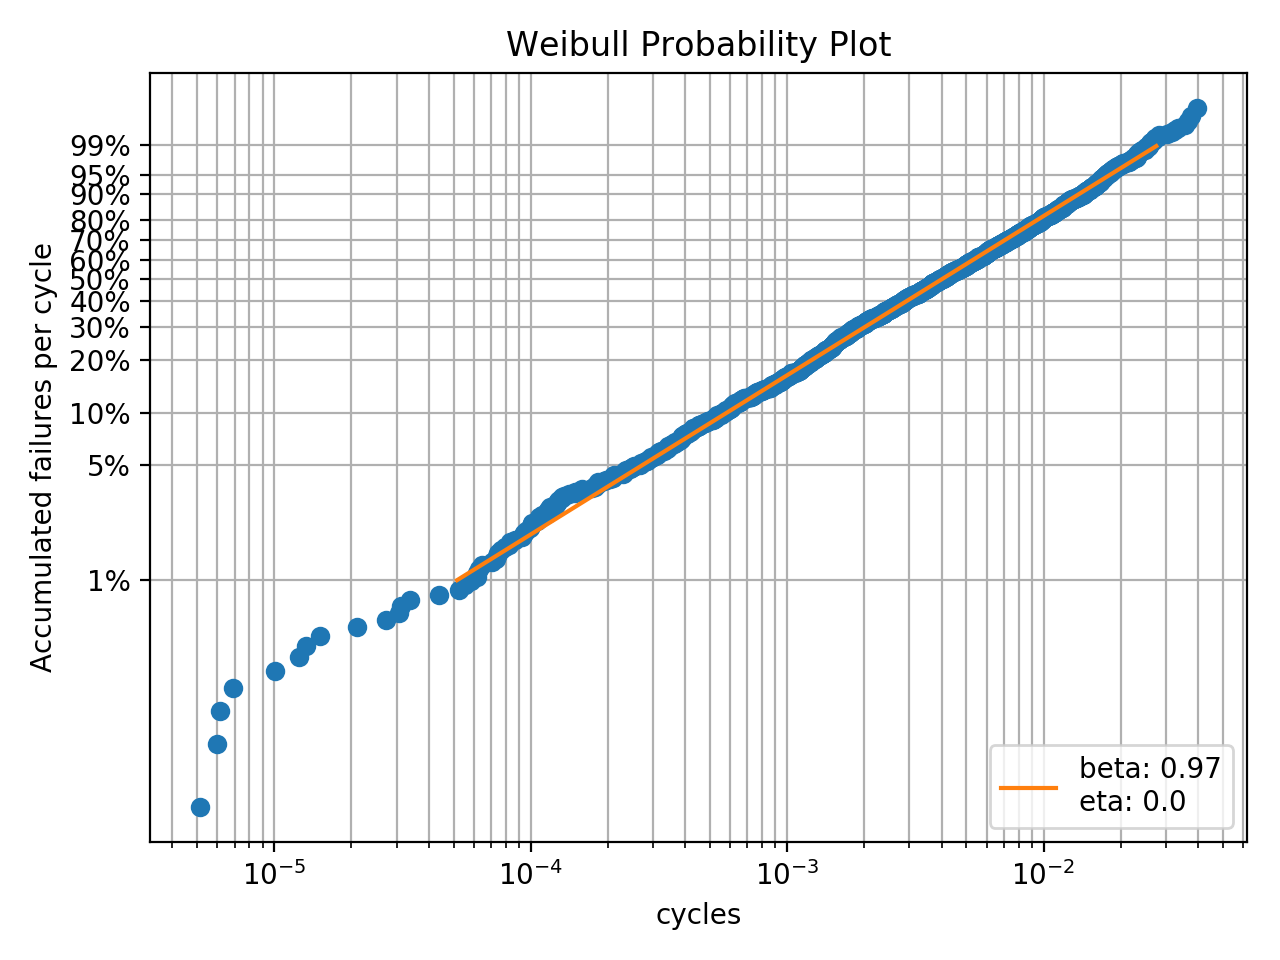

fit method          maximum likelihood estimation
confidence                                    0.9
beta lower limit                         0.942511
beta nominal                             0.972814
beta upper limit                          1.00409
eta lower limit                        0.00557564
eta nominal                            0.00582302
eta upper limit                        0.00608139
mean life                              0.00589371
median life                            0.00399508
b10 life                              0.000576122
dtype: object
0.972814161435
0.00582302375313
0.0763087396903


In [28]:
#does weibull analysis on experimental data
analysis = weibull.Analysis(Z2flat)
analysis.fit(method='mle')
plt.figure()
analysis.probplot()
print(analysis.stats)
beta = analysis.beta
eta = analysis.eta
print(beta)
print(eta)

# These numbers need to be extracted from the weibull fitting routine
sigma2W = eta
print(np.sqrt(sigma2W))
etaW = beta


<IPython.core.display.Javascript object>


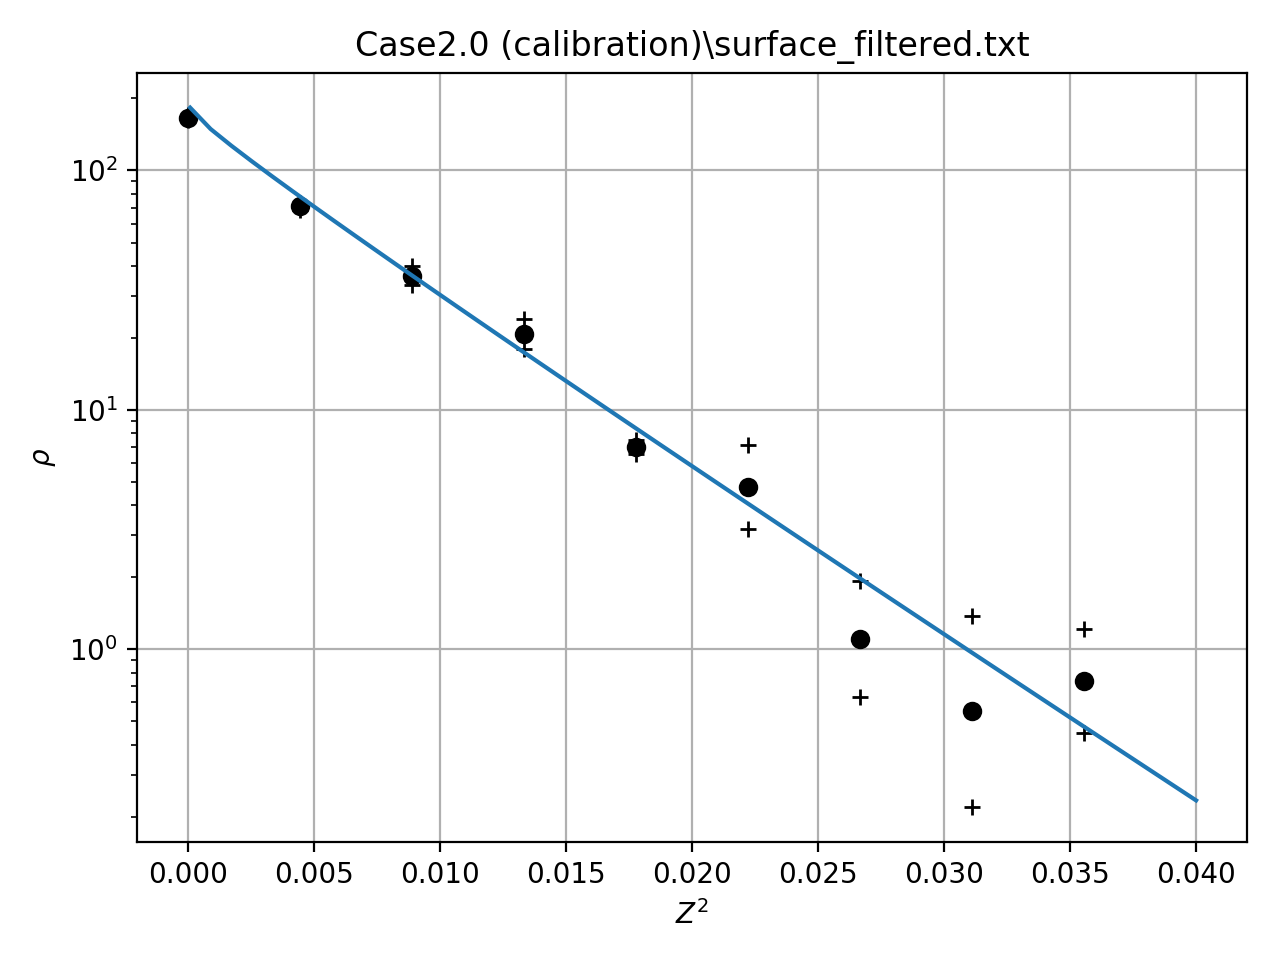

[ 166.40816327   70.89795918   36.36734694   20.75510204    6.97959184
    4.7755102     1.10204082    0.55102041    0.73469388]
[ 170.01145406   73.42342155   39.97063774   23.8847545     7.45685936
    7.16184783    1.92869242    1.37767201    1.2119614 ]
[ 162.88124205   68.45936229   33.0888872    18.03553228    6.53287126
    3.18430358    0.6296981     0.22038881    0.44537317]


In [29]:
# Graph the experimental distribution function
fig = plt.figure()
plt.semilogy(bins, counts, 'ok', label='Numerical result')

# Graphing the error bars (sloppily)
print(counts)
countsplus = counts+error; print(countsplus)
countsminus = counts**2/countsplus; print(countsminus)
plt.semilogy(bins, countsplus, '+k')
plt.semilogy(bins, countsminus,'+k')

# Cosmetics
plt.grid(True)
plt.xlabel('$Z^2$')
plt.ylabel(r'$\rho$')
plt.title(foldername+slash+filename)

# Graph the best-fit distribution function
Z2 = np.linspace(0.0001,Z2max,50)
myWeibull = Weibull(Z2,sigma2W,etaW)
plt.semilogy(Z2, myWeibull)
plt.grid(True)